In [1]:
# 1. Import thư viện cần thiết
# from google.colab import drive
# drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Bidirectional

In [2]:
# 2. Đọc file csv và gắng index với giá Close
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FPT Historical Data 10 years.csv')
df = pd.read_csv('../Datasets/NVDA Historical Data.csv')
df1=df.reset_index()['Price']
df.size

11368

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

# time_step = 100
# X_train, y_train = create_dataset(train_data, time_step)
# X_val, yval = create_dataset(val_data, time_step)
# X_test, ytest = create_dataset(test_data, time_step)

In [7]:
#6. New

time_step = 100
X, y = create_dataset(df1, time_step)

X_train = X[:train_size-100]
X_test = X[train_size-100:train_size-100+test_size]
X_val = X[train_size-100+test_size:]

y_train = y[:train_size-100]
ytest = y[train_size-100:train_size-100+test_size]
yval = y[train_size+test_size-100:]

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [9]:
# 8. Define LSTM Model
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_step,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add a bidirectional LSTM layer
model.add(LSTM(100, activation='relu'))

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 2s 59ms/step - loss: 0.0061 - val_loss: 0.0240
Epoch 2/100
14/14 [==============================] - 1s 47ms/step - loss: 0.0019 - val_loss: 0.0144
Epoch 3/100
14/14 [==============================] - 1s 51ms/step - loss: 3.9619e-04 - val_loss: 0.0123
Epoch 4/100
14/14 [==============================] - 1s 62ms/step - loss: 2.2057e-04 - val_loss: 0.0039
Epoch 5/100
14/14 [==============================] - 1s 59ms/step - loss: 1.4649e-04 - val_loss: 0.0040
Epoch 6/100
14/14 [==============================] - 1s 60ms/step - loss: 1.2985e-04 - val_loss: 0.0048
Epoch 7/100
14/14 [==============================] - 1s 55ms/step - loss: 1.2288e-04 - val_loss: 0.0051
Epoch 8/100
14/14 [==============================] - 1s 55ms/step - loss: 1.1800e-04 - val_loss: 0.0051
Epoch 9/100
14/14 [==============================] - 1s 56ms/step - loss: 1.1434e-04 - val_loss: 0.0045
Epoch 10/100
14/14 [==============================] - 1s 58ms/step - los

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

6/6 [==============================] - 0s 9ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))

In [14]:
# 13. Dự báo 30 ngày tiếp theo

# n_steps=100
# x_input=val_data[60:].reshape(1,-1)

n_steps=time_step
x_input=val_data[-n_steps:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
i=0
while(i<30):
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.742752]
101
1 day input [0.41704014 0.42883526 0.44269884 0.4130756  0.42230978 0.45693179
 0.47579414 0.46079783 0.46052696 0.4872199  0.48800788 0.49125831
 0.46486087 0.47773947 0.50687023 0.50177296 0.48300911 0.46788968
 0.44983994 0.45227776 0.52393499 0.51462694 0.5199212  0.51290323
 0.50014775 0.51531642 0.52950012 0.5212263  0.51467619 0.53666585
 0.51832061 0.50672248 0.50674711 0.53376016 0.5378232  0.57015513
 0.57468604 0.57899532 0.58635804 0.59298202 0.61078552 0.60064024
 0.59453337 0.5915538  0.60568825 0.61551342 0.62521546 0.62984487
 0.61723713 0.60315193 0.60699335 0.62033982 0.61024378 0.59364689
 0.5928589  0.60012312 0.60613149 0.62250677 0.62900763 0.60864319
 0.60901256 0.60711647 0.58739227 0.60499877 0.61164738 0.62452598
 0.653115   0.63587786 0.62583108 0.6199212  0.64745137 0.6590495
 0.6447673  0.65249938 0.64493967 0.63907904 0.65417385 0.66057621
 0.68433883 0.72127555 0.71108101 0.70891406 0.69689732 0.69320364
 0.876459   0.90024624 0.92893376 0.

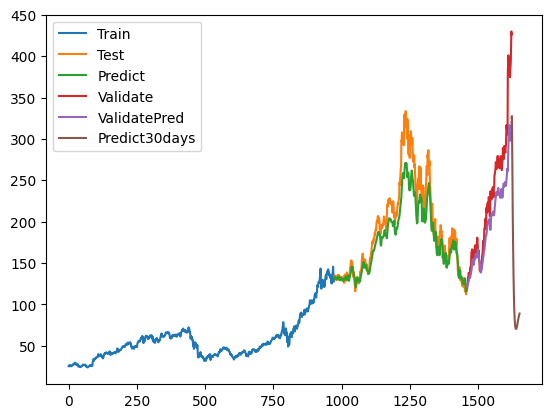

In [15]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [16]:
def mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Regression metrics
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mse = mean_squared_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)
test_mape = mape(ytest, y_pred)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
valid_mse = mean_squared_error(yval, y_pred_val)
valid_mae = mean_absolute_error(yval, y_pred_val)
valid_mape = mape(yval, y_pred_val)

print('Testing RMSE:', test_rmse)
# print('Testing MSE:', test_mse)
print('Testing MAE:', test_mae)
print("Testing MAPE:", test_mape)

print('Validation RMSE:', valid_rmse)
# print('Validation MSE:', valid_mse)
print('Validation MAE:', valid_mae)
print("Validation MAPE:", valid_mape)

Testing RMSE: 179.81110503912467
Testing MAE: 175.2735873606423
Testing MAPE: 47307.54793338085
Validation RMSE: 205.82275241131157
Validation MAE: 199.47403664493473
Validation MAPE: 44821.196902606716


In [17]:
print(scaler.inverse_transform(lst_output)[:10, 0])

[325.50159353 327.68882186 290.59150654 253.45965004 211.49186006
 181.07159287 156.00552199 134.14922641 116.45761703 100.03056068]


In [18]:
print(df['Price'].tail(10))

1614    393.27
1615    391.71
1616    386.54
1617    374.75
1618    385.10
1619    387.70
1620    394.82
1621    410.22
1622    429.97
1623    426.53
Name: Price, dtype: float64


In [19]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

# pred_ind = list(range(len(df1), len(df1)+30))
# x_train_ind = list(range(0, train_size))
# x_test_ind = list(range(train_size, train_size+test_size))
# x_validation_ind = list(range(train_size+test_size, len(df1)))
# pred_ind = list(range(len(df1), len(df1)+30))

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data_index, y=scaler.inverse_transform(train_data)[:, 0], mode='lines+markers', marker=dict(size=4),  name='Train', marker_color='#1F77B4'))
fig.add_trace(go.Scatter(x=test_data_index,y=scaler.inverse_transform(test_data)[:, 0], mode='lines+markers', marker=dict(size=4), name='Test', marker_color='#FF7F0E'))
fig.add_trace(go.Scatter(x=test_pre_data_index,y=y_pred[:, 0], mode='lines+markers', marker=dict(size=4), name='Prediction', marker_color='#2CA02C'))
fig.add_trace(go.Scatter(x=val_data_index, y=scaler.inverse_transform(val_data)[:, 0], mode='lines+markers', marker=dict(size=4), name='Validate', marker_color='#D62728'))
fig.add_trace(go.Scatter(x=val_pre_data_index, y=y_pred_val[:, 0], mode='lines+markers', marker=dict(size=4), name='Validate', marker_color='#9569BE'))
fig.add_trace(go.Scatter(x=prediect_data_index, y=scaler.inverse_transform(lst_output)[:, 0], mode='lines+markers', marker=dict(size=4), name='Next30Day', marker_color='#000000'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',  
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),    
                  title_text = f'NVDA CNN_Bi_LSTM data (6:3:1)', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

NameError: name 'test_pre_data_index' is not defined

In [ ]:
len(df1)

1624

In [ ]:
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)

In [ ]:
prediect_data_index

RangeIndex(start=1623, stop=1653, step=1)

In [ ]:
prediect_data_index = pd.RangeIndex(start=len(df1), stop=len(df1)+30, step=1)

In [ ]:
prediect_data_index

RangeIndex(start=1624, stop=1654, step=1)

In [ ]:
len(val_data)

163

In [ ]:
len(df1) - len(train_data) - len(test_data)

163

In [ ]:
len(train_data) 

974

In [ ]:
test_data_index

RangeIndex(start=974, stop=1461, step=1)

In [ ]:
len(train_data) + len(test_data)

1461

In [ ]:
val_data_index

RangeIndex(start=1461, stop=1624, step=1)

In [ ]:
prediect_data_index

RangeIndex(start=1624, stop=1654, step=1)